In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import RandomSampler, BatchSampler, SequentialSampler, random_split, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.jit import save, load

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    
def train(model, device, train_loader, optimizer, epoch, loss_history, acc_history):
    model.train()
    correct = 0
    train_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    acc = 100. * correct / len(train_loader.dataset)
    train_loss /= len(train_loader)
    loss_history.append(train_loss)
    acc_history.append(acc)
    print(f'Train Epoch: {epoch}\nTraining Loss: {train_loss}\tAccuracy: {acc:.4f}')
    
def val(model, device, val_loader, loss_history, acc_history):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    val_loss /= len(val_loader.dataset)
    acc = 100. * correct / len(val_loader.dataset)
    loss_history.append(val_loss)
    acc_history.append(acc)
    
    print(f'Validation Loss: {val_loss}, Accuracy: {acc:.4f}\n')
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss}, Accuracy: {acc:.4f}')
    

# set random seed
torch.manual_seed(198964)

#set device
device = torch.device('cuda')

# arguments
batch_size = 64
test_batch_size = 1000
lr = 1.0
gamma = 0.7
epochs = 14

# transform
train_tf=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])
eval_tf=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])

# import data
train_data = datasets.MNIST(root='../data', train=False, download=True,
                            transform=train_tf)
test_data = datasets.MNIST(root='../data', train=False, download=True, 
                           transform=eval_tf)
(test_data, val_data) = random_split(test_data, [5000, 5000])

# kwargs
train_kwargs = {'batch_sampler': BatchSampler(sampler=RandomSampler(train_data),
                                              batch_size=batch_size,
                                              drop_last=False),
                'num_workers':3}
val_kwargs = {'batch_sampler': BatchSampler(sampler=SequentialSampler(val_data),
                                              batch_size=test_batch_size,
                                              drop_last=False), 
              'num_workers':3}
test_kwargs = {'batch_sampler': BatchSampler(sampler=SequentialSampler(test_data),
                                              batch_size=test_batch_size,
                                              drop_last=False),
               'num_workers':3}

# dataloader
train_loader = DataLoader(train_data, **train_kwargs)
val_loader = DataLoader(val_data, **val_kwargs)
test_loader = DataLoader(test_data, **test_kwargs)

# build model
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size = 1, gamma=gamma)
train_loss, val_loss = [], []
train_acc, val_acc = [], []

In [8]:
for epoch in range(1, epochs+1):
    train(model, device, train_loader, optimizer, epoch, train_loss, train_acc)
    val(model, device, val_loader, val_loss, val_acc)
    scheduler.step()
    
test(model, device, test_loader)

Train Epoch: 1
Training Loss: 0.5126446617921446	Accuracy: 83.3500
Validation Loss: 0.10710512237548828, Accuracy: 96.5600

Train Epoch: 2
Training Loss: 0.14457440939820876	Accuracy: 95.3700
Validation Loss: 0.04711164855957031, Accuracy: 98.6200

Train Epoch: 3
Training Loss: 0.09522251984709577	Accuracy: 97.0000
Validation Loss: 0.03161551628112793, Accuracy: 99.0200

Train Epoch: 4
Training Loss: 0.07501378790979647	Accuracy: 98.0100
Validation Loss: 0.0224038480758667, Accuracy: 99.2200

Train Epoch: 5
Training Loss: 0.05797807570579491	Accuracy: 98.2400
Validation Loss: 0.017364588737487793, Accuracy: 99.4400

Train Epoch: 6
Training Loss: 0.05012429650253053	Accuracy: 98.5700
Validation Loss: 0.013983384513854981, Accuracy: 99.5600

Train Epoch: 7
Training Loss: 0.043273142107412406	Accuracy: 98.6400
Validation Loss: 0.012782034778594971, Accuracy: 99.6400

Train Epoch: 8
Training Loss: 0.04001055346137494	Accuracy: 98.7700
Validation Loss: 0.010830975818634033, Accuracy: 99.640

畫出比較圖

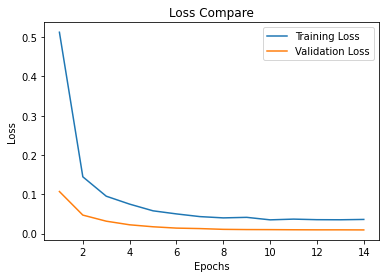

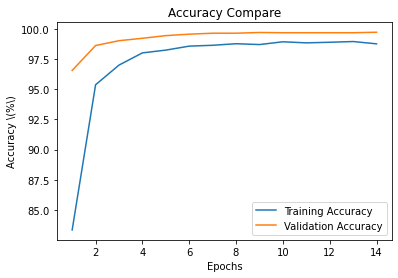

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, epochs+1)
loss_graph = plt.subplot(title='Loss Compare', xlabel='Epochs', ylabel='Loss')
loss_graph = plt.plot(x, train_loss, label='Training Loss')
loss_graph =  plt.plot(x, val_loss, label='Validation Loss')
plt.legend()
plt.show()
acc_graph = plt.subplot(title='Accuracy Compare', xlabel='Epochs', ylabel=r'Accuracy \(%\)')
acc_graph = plt.plot(x, train_acc, label='Training Accuracy')
acc_graph = plt.plot(x, val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

儲存module的script和model的state_dict

In [47]:
from torch.jit import save, load, script

m = script(Net())
save(m, 'mnist_module.pt')
torch.save(model.state_dict(), 'mnist_state_dict.pt')